# Introduction
The previous stage includes businesses clustering, which is in Preprocess_Businesses.ipynb<br>
The following stage is aim to preprocess reviews text

In [1]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
from wordcloud import WordCloud
import re
import spacy
nlp = spacy.load('en_core_web_sm')
import string
from sklearn.utils import resample
import sys
import os
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

import matplotlib.pyplot as plt
%matplotlib inline

# Load reviews
In the previous stage, we filtered the user reviews we needed by some factors such as state, city, category in Business dataset. In this step we will build a text classifier using Python’s Pandas, NLTK and Scikit-learn libraries. We will explore Reviews dataset, look for correlations between the data, use natural language processing (NLP) to process the text, and build a sentiment analysis model that predicts whether a user liked a local restaurant or not, based on their review on Yelp.

In [3]:
file = "Restaurant_Reviews_Dataset.csv"
df = pd.read_csv(file)
df['text length'] = df['text'].apply(len)
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,text length
0,NMtUD873aWrNjljt3VOcFA,0,2015-04-28 19:43:37,0,Dkv4YJVG3vOg12i3GJxc-g,4,Chef Kevin Sbraga knows fried chicken. My firs...,0,5kcLlhJPLJL_GLwrAdbZAA,1165
1,7lwe7n-Yc-V9E_HfLAeylg,2,2010-05-14 15:28:59,2,4PRGgyiaeTuiNeG8fSTPhg,3,"by 3 stars, i really mean 3.5-\n\nwhite brick ...",2,be1dU739NLAFbLw2S4RPhA,1056
2,1NCUTTp6rIyXpwUDVv9qOA,0,2016-02-23 22:20:29,0,XWs3JW2wboGq_aIUk81Pzw,4,The pizza was the best we've had in the Fairmo...,0,XQHA8cLOM5vztrYU0TWPrw,398
3,uE40984_YDgVvPeRpFcCaQ,0,2016-03-07 00:32:01,0,-QMY6GJ1rHGVlOyKBHgV1g,4,The hot chicken is probably one of the best fr...,0,wABHp4fGUC-0acRKhmQO2A,235
4,DSGHZnDLRbR9wk-u1trRUQ,0,2015-08-30 14:52:02,1,XVqGZWrpe_1atDtptQl_3w,3,Worn down signs intrigue me. I had biked pass...,1,vr-Rw3nMKIgGrVNT6A7p9g,1292


In [4]:
df.describe()

,cool,funny,stars,useful,text length
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.584600,0.375400,3.922400,1.074200,629.381600
std,2.029598,1.446684,1.250076,2.565465,560.863688
min,0.000000,0.000000,1.000000,0.000000,27.000000
25%,0.000000,0.000000,3.000000,0.000000,252.750000
50%,0.000000,0.000000,4.000000,0.000000,459.500000
75%,1.000000,0.000000,5.000000,1.000000,821.000000
max,71.000000,49.000000,5.000000,78.000000,4972.000000


# Search for collerations and features
Seaborn's FacetGrid allows us to create a grid of bar charts placed side-by-side. We use FacetGrid to see if there is any relationship between the text length characteristics of user reviews and star ratings.

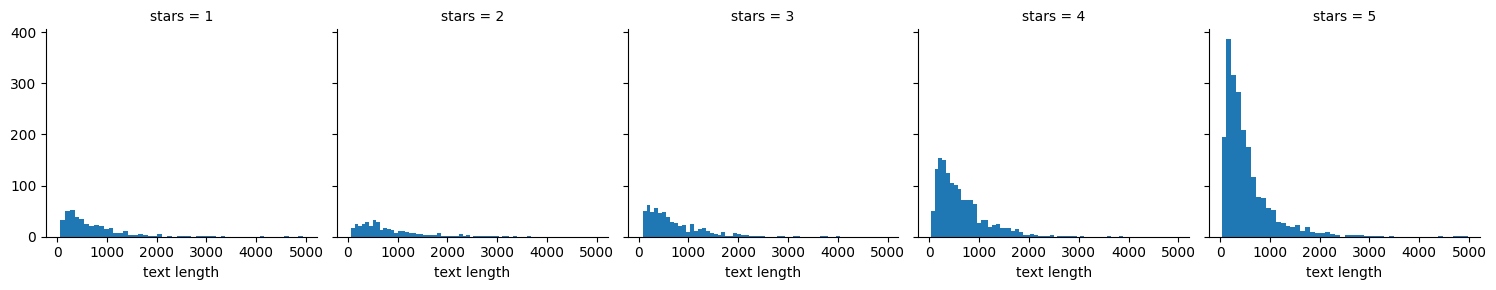

In [5]:
g = sns.FacetGrid(data=df, col='stars')
g.map(plt.hist, 'text length', bins=50)

从五张图的分布可以看出，大多数评论的文本长度都在0～1000左右，随着文本长度的增加，评论的数量越来越少。

In [6]:
stars = df.groupby('stars').mean()
stars.corr()

,cool,funny,useful,text length
cool,1.000000,-0.746424,-0.635992,-0.777076
funny,-0.746424,1.000000,0.975941,0.555388
useful,-0.635992,0.975941,1.000000,0.564912
text length,-0.777076,0.555388,0.564912,1.000000


<AxesSubplot: >

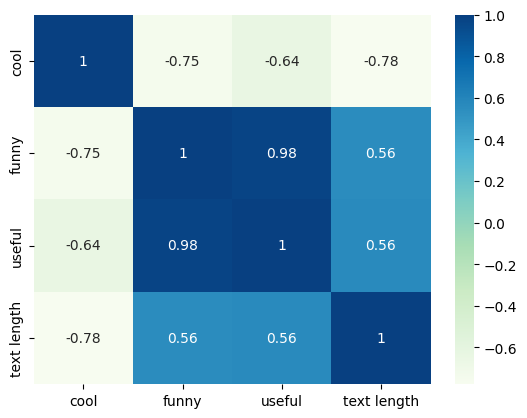

In [7]:
sns.heatmap(data=stars.corr(), annot=True, cmap="GnBu")

Accordimg to the heat map, text length is strongly correlated with funny and useful, and useful seems strongly correlated with funny. We can also see a negative correlation between cool and the other three features.
根据热图，文本长度与有趣和有用密切相关，而有用似乎与有趣密切相关。我们还可以看到酷与其他三个特征之间存在负相关。

# Filter experiment sample and balance sample
我们首先的任务是区分评论是正面还是负面，所以我们先通过stars作为参考，将3星以上的评论归类为1（积极评论），将3星以下的评论归类为0（消极评论），并将他们存在新的列target里

In [11]:
df = df[(df["stars"]!=3)]
df.loc[df['stars'] < 3, 'target'] = 0 
df.loc[df['stars'] > 3, 'target'] = 1

df_target = df[['review_id','business_id','text','target']]
df_target

,review_id,business_id,text,target
0,Dkv4YJVG3vOg12i3GJxc-g,NMtUD873aWrNjljt3VOcFA,Chef Kevin Sbraga knows fried chicken. My firs...,1.0
2,XWs3JW2wboGq_aIUk81Pzw,1NCUTTp6rIyXpwUDVv9qOA,The pizza was the best we've had in the Fairmo...,1.0
3,-QMY6GJ1rHGVlOyKBHgV1g,uE40984_YDgVvPeRpFcCaQ,The hot chicken is probably one of the best fr...,1.0
5,VairgP5nQwKofVCI2E7mAw,uKAbrDSJJzZliY1Yqu5KxQ,Our Friday night party of eight could not have...,1.0
6,1HP3yZN3jT646IlHSo7GZw,YtSqYv1Q_pOltsVPSx54SA,been to nearly all the high-end steak houses i...,1.0
...,...,...,...,...
4994,7Y__TY0zSJpAaFVB-oVnnA,ytynqOUb3hjKeJfRj5Tshw,I love it here! There's always something to se...,1.0
4995,MaJZ-5DQ6IC4Pur_SRv0gw,saVXla5i8TjE51S5uCaf6w,My girlfriend and I came here for a birthday. ...,1.0
4996,oxo2MvPe_BX6ABNLBX4LIA,p2LfPp--eXZQzKtMdDL2aA,"This is a great spot for pasta, they have hear...",1.0
4998,MUfVEjaqUBKaan3-xRXUcA,ytynqOUb3hjKeJfRj5Tshw,MUST SEE! You are a fool to come to Philadelp...,1.0


1.0    3626
0.0     775
Name: target, dtype: int64


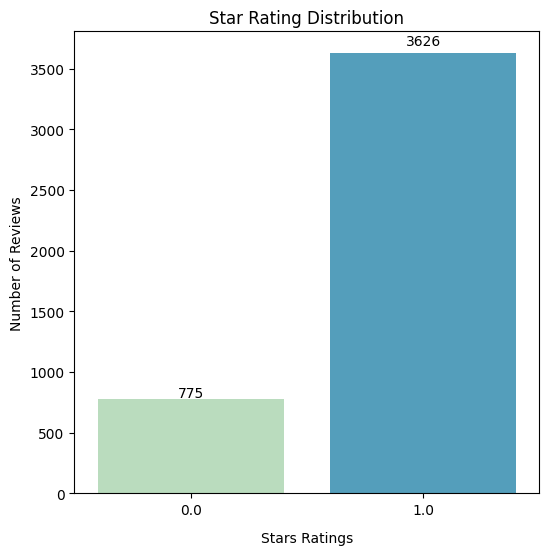

In [12]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

plt.figure(figsize=(6,6))
grouped = df_target.target.value_counts().sort_index()
print(df_target.target.value_counts())
sns.barplot(x=grouped.index, y=grouped.values, palette=sns.color_palette("GnBu", len(grouped)))
plt.xlabel("Stars Ratings", labelpad=10, fontsize=10)
plt.ylabel("Number of Reviews", fontsize=10)
plt.title("Star Rating Distribution", fontsize=12)
plt.tick_params(labelsize=10)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ="center",fontsize=10)

从上图不难看出积极和消极的评论的数量是完全不平衡的，为了让实验更加公平，我们要handle class imbalance using Sklearn Resample<br>
【摘抄】如果正负样本差别很大，或是类别与类别之间相差很大，那么模型就会偏向于预测最常出现的样本。虽然说这样做最后可以获得较高的准确率，但是这个准确率不能说明模型有多好。解决样本不平衡的问题，有两个大的方向是可以解决的。一个是under-sampling，另一个是over-sampling。(A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).<br><br>
We use over-sampling here, upsample minority class (negative review class)

In [14]:
# upsample minority class
# create two different dataframes: one regarding the majority and the other the minority class 
df_majority = df_target[(df_target['target']==1)] 
df_minority = df_target[(df_target['target']==0)] 

df_minority_upsampled = resample(df_minority, 
                                 replace=True,   
                                 n_samples= df_target.target.value_counts()[1], # to match majority class
                                 random_state=42)  
# Combine majority class with upsampled minority class
df_target = pd.concat([df_minority_upsampled, df_majority])

Reason for balancing positvie and negative reviews:
- As we can see our positive reviews are significantly higher than negative reviews, if we using this data to analyze, it will be more biased towards positive reviews compared to negative reviews.  

0.0    3626
1.0    3626
Name: target, dtype: int64


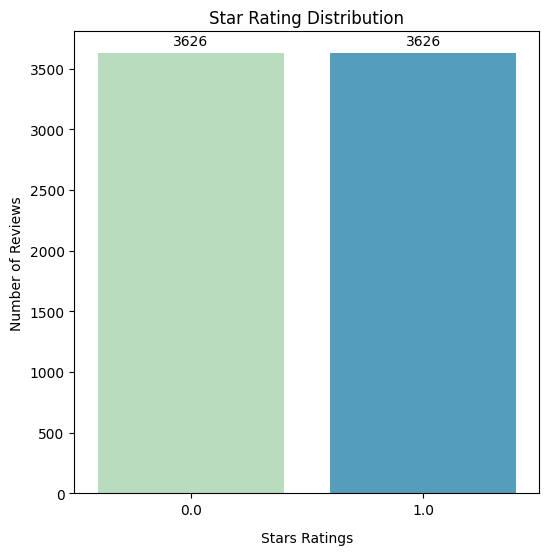

In [15]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

plt.figure(figsize=(6,6))
grouped = df_target.target.value_counts().sort_index()
print(df_target.target.value_counts())
sns.barplot(x=grouped.index, y=grouped.values, palette=sns.color_palette("GnBu", len(grouped)))
plt.xlabel("Stars Ratings", labelpad=10, fontsize=10)
plt.ylabel("Number of Reviews", fontsize=10)
plt.title("Star Rating Distribution", fontsize=12)
plt.tick_params(labelsize=10)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ="center",fontsize=10)

# Clean review texts

In [22]:
sample_text = df_target['text'][6]
sample_text

"been to nearly all the high-end steak houses in Philly, this might just be my favorite.  Right up there with Barclay Prime, though two totally different joints.  This is your classic old school place.  Waiter we had was amazing, and that never hurts your experience.  Everything we ate was great - apps, sides, meats, desserts.\\n\\n100% I recommend getting the prime rib.  We got a steak and a prime rib and split the two.  they didn't name the place 'the prime rib' for no reason, right?  Probably the best prime rib I've ever had, was way better than their filet, makes it a unique experience from the other steak joints in town."

通告观察该数据集第一行的文本，我们发现文本是plain-text format，里面包含了类似于\n这些我们不需要的内容

【摘抄】The classification algorithm will need some sort of feature vector in order to perform the classification task. The simplest way to convert a corpus to a vector format is the bag-of-words approach, where each unique word in a text will be represented by one number.分类算法需要某种特征向量来执行分类任务。将语料库转换为矢量格式的最简单方法是bag-of-words方法，其中文本中的每个唯一单词将由一个数字表示。<br>
First, let’s write a function that will split a message into its individual words, and return a list. We will also remove the very common words (such as “the”, “a”, “an”, etc.), also known as stopwords. To do this, we can take advantage of the NLTK library. The function below removes punctuation, stopwords, and returns a list of the remaining words, or tokens.
首先，让我们编写一个函数，将一条消息拆分成单独的单词，并返回一个列表。我们还将删除非常常见的词（例如“the”、“a”、“an”等），也称为停用词。为此，我们可以利用 NLTK 库。下面的函数删除标点符号、停用词，并返回剩余单词或标记的列表。

In [23]:
"""
    logging: 

    if it throws out error as
        ModuleNotFoundError: No module named 'en_core_web_sm',
    make sure that your virtual environment has installed spacy and en_core_web_sm, you can follow the below commands
        pip install -U spacy
        python -m spacy download en_core_web_sm
    my python version is 3.8, and then you can go back JupyterLab and run 
        spacy.load('en_core_web_sm')
    
    reference: 
        https://stackoverflow.com/questions/69284181/modulenotfounderror-no-module-named-en-core-web-sm  
"""
nlp = spacy.load('en_core_web_sm')

首先使用正则表达式去掉了文本中的URL网址，@用户，#hashtag标签，然后去掉stopwords。这里我使用spacy库提供的默认的stopwords，但是去掉了其中的'over','less','few','many','more','nothing','nobody','none'，因为这些词依然有很强的情感偏向，所以我选择将它们保留在文本中。接下来我们需要对文本进行Stemming and lemmatization 【paper部分在可以稍微解释一下这两个概念】，将单词转变为token，去掉了不是字母组成的token，并且将它们转化为小写

In [39]:
def text_clean(text):
    # remove the URL
    text = re.sub(r"http\S+", "", text)
    # remove mentions
    text = re.sub("@[^\s]*", "", text)
    # remove hashtags
    text = re.sub("#[^\s]*", "", text)
    # remove stopwords, but skip "no", "not"
    """
        reference:
            https://stackabuse.com/removing-stop-words-from-strings-in-python/
    """
    stopwords = nlp.Defaults.stop_words
    exclude_stopwords = {'over','less','few','many','more','nothing','nobody','none'}
    for word in exclude_stopwords:
       stopwords -= {word}
    
    return spacy_process(text)

def spacy_process(text):
    doc = nlp(text)
    
    # Lemmatization with Spacy
    lemma_list = []
    for token in doc:
        lemma_list.append(token.lemma_)
            
    #Filter the stopwords, remove non-letters and lower case 
    filtered_sentence =[]
    for word in lemma_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
    lower_words = []
    for word in filtered_sentence:
        text_letters_only = re.sub("[^a-zA-Z]", " ", word)
        text_words_lower = text_letters_only.lower()
        lower_words.append(text_words_lower)
    text_final = " ".join(lower_words)
    return  " ".join(text_final.split())

运行使用text_clean后的sample_text的结果,there are no punctuations or stopwords, and the remaining words are returned to us as a list of tokens，但是在这里我还是选择转为一个长string，方便之后使用

In [40]:
text_clean(sample_text)

'nearly high end steak house philly favorite right barclay prime totally different joint classic old school place waiter amazing hurt experience eat great app meat desserts n n recommend prime rib steak prime rib split place prime rib reason right probably good prime rib way filet unique experience steak joint town'

我们发现此时句子已经被分解成一个一个单词了，接下来将这个步骤用到dataframe的每一个review里，并且将结果存在cleaned_text的列里，这一步需要等待一段时间

In [41]:
df_target['cleaned_text'] = df_target['text'].apply(text_clean)
df_target.head()

,review_id,business_id,text,target,cleaned_text
519,Gt_h5A-A5Nt50EbaPCorvw,F8yozE3NWnImNApHO347gQ,First impression was good but their food is ho...,0.0,impression good food horrible cash idea over p...
2535,0dELc-isYD5Av7KNsIvcRA,WxB8498ejPtHE7wFa89_fA,"I've been to this location countless times, an...",0.0,location countless time time food service ambi...
1645,Bmrq4dvmlVMGU3roXzeDgQ,-mIlmp5l4hKlp1tvHRdvTg,Seems popular- but not that delish. Short sub ...,0.0,popular delish short sub maybe typical length ...
554,tCP2EjtzGJ7JEHlj_8i1xw,hcxea89M_U__LADtu3C0kA,The service was great! The place was very beau...,0.0,service great place beautiful small tight rest...
380,3gM_kcsqfU9eqmE19kL4tw,3BJxm-HnvzdwD1zjmSbmyQ,I was at this restaurant recently and was so u...,0.0,restaurant recently unhappy purchase wonton so...


In [42]:
df_target.to_csv("Cleaned_Text_Dataset.csv")

# Word Cloud 
我们已经通过stars粗略的做了一个评论的积极/消极的区分，并且clean了所有评论的文本，现在简单的通过word cloud的方式观察这些评论里出现的词频

In [43]:
pos = df_target[df_target['target']==1]['cleaned_text']
neg = df_target[df_target['target']==0]['cleaned_text']

### positive review word cloud 呈现正面评论或赞美中出现的词频。

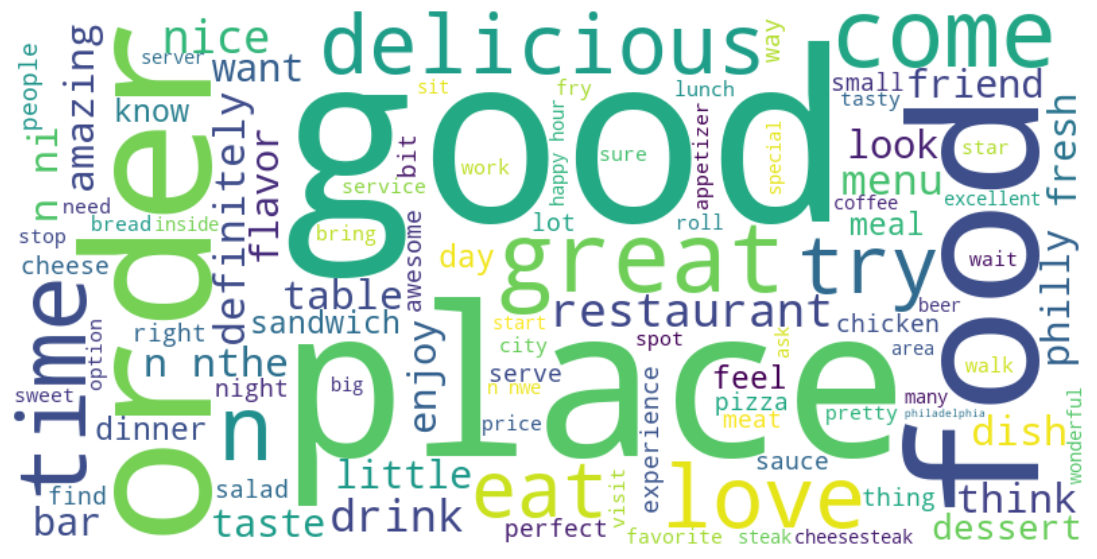

In [44]:
text_pos = " ".join(i for i in pos)
wc_pos = WordCloud(background_color="white", max_words=100, contour_width=10, contour_color='firebrick',
                   width=800, height=400)

# Generate a wordcloud
wc_pos.generate(text_pos)

plt.figure(figsize=(14,7))
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

### negative review word cloud 呈现差评或投诉中的词频

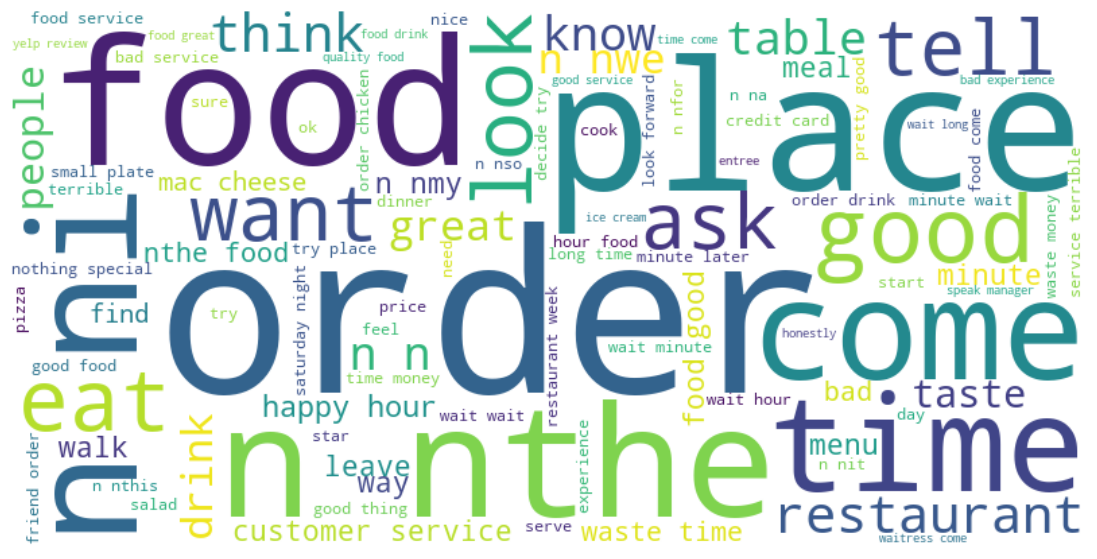

In [45]:
text_neg = " ".join(i for i in neg)
wc_neg = WordCloud(background_color="white", max_words=100, contour_width=10, contour_color='firebrick',
                   width=800, height=400)

wc_neg.generate(text_neg)

plt.figure(figsize=(14,7))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis("off")
plt.show()